This is the driver program for the ARIMA process. 

- It starts with testing stationarity.
- Then it runs a grid search for the best parameters. It returns the best parameters and we use those going forward.
- Then we summarize residual errors for the model.
- Then we summarize residual errors from bias corrected forecasts.
- Plots test vs prediction scores
- Saves finalized model to file
- Loads the finalized model and makes a prediction. This proves that it works.
- Then finally we forecast for the balance of the year.

In [44]:
# import libraries
import pandas as pd
import pickle
import stationarity as st
import load_data as ld
import arima_grid_search as ags
import summarize
import test_prediction_save_forecast_1day as tpsf1
import multi_step_forecast as msf

In [45]:
# Prepare arguments for driver
arg_dict = {'file_name_1': r'data\all_df.csv',
            'file_name_2': r'C:\Users\linds\OneDrive\mystuff\GitHub\covid\data\country_codes_edited.csv',
            'feature': 'Province_State',
            'place': 'New York',
            'dependent_variable': 'Deaths',
            'path': r'C:\Users\linds\OneDrive\mystuff\GitHub\COVID-19\csse_covid_19_data\csse_covid_19_daily_reports',
            'best_cfg': (1,1,0), # I initially tried p,d,q of 7,2,0 based on the ACF and PACF. It did not converge.
            'p_values': range(0,3),
            'd_values': range(0,3),
            'q_values': range(0,3),
            'split_value': .5,
            'bias': 0,
            'date': '12-31-2020'}

The "data date" is 2020-05-20 00:00:00

ADF Statistic: -4.195755
p-value: 0.000670
Critical Values:
	1%: -3.534
	5%: -2.906
	10%: -2.591


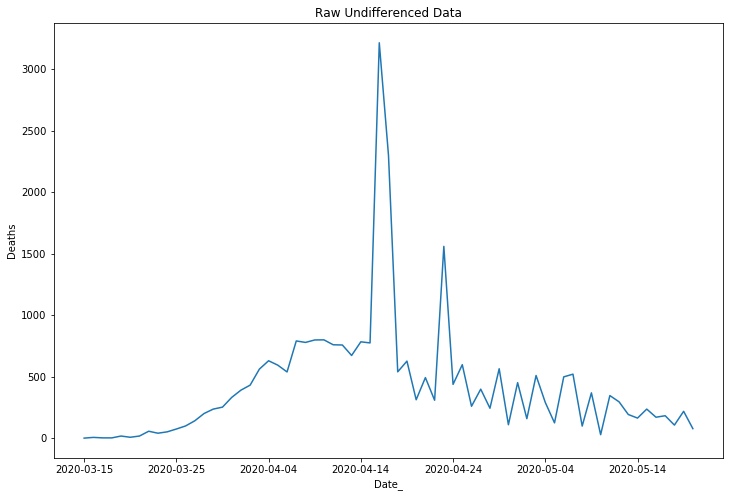

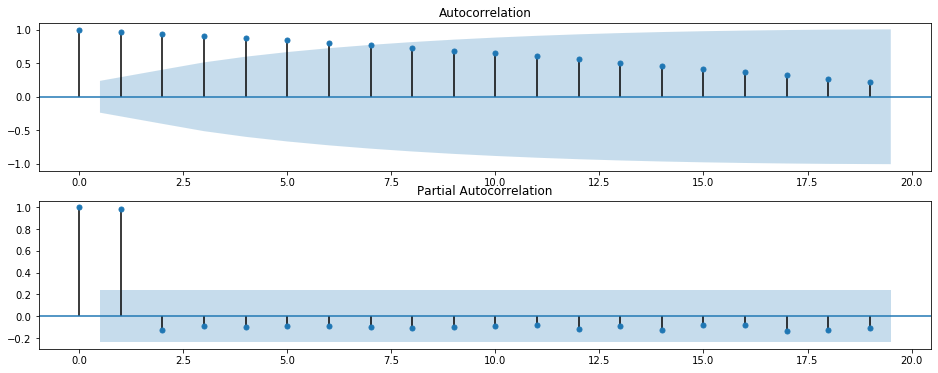

ARIMA(0, 0, 1) RMSE=12195.362
ARIMA(0, 1, 1) RMSE=498.595
ARIMA(0, 1, 2) RMSE=551.792
ARIMA(0, 2, 1) RMSE=481.182
ARIMA(0, 2, 2) RMSE=650.544
ARIMA(1, 0, 0) RMSE=592.092
ARIMA(1, 1, 0) RMSE=446.382
ARIMA(1, 2, 0) RMSE=505.378
ARIMA(2, 1, 0) RMSE=491.886
ARIMA(2, 2, 0) RMSE=693.537
Best ARIMA(1, 1, 0) RMSE=446.382
RMSE: 446.382
                 0
count    34.000000
mean      1.017374
std     453.093973
min   -1527.526943
25%    -151.051102
50%       8.376551
75%     242.505669
max    1321.762803


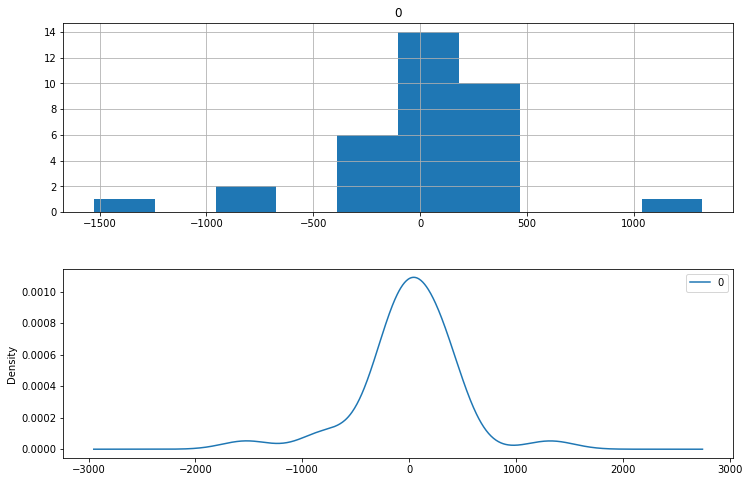


bias IS saved in arg_dict["bias"] for subsequent run is: 1.0173743452477912 

RMSE: 446.381
                  0
count  3.400000e+01
mean   8.559950e-13
std    4.530940e+02
min   -1.528544e+03
25%   -1.520685e+02
50%    7.359177e+00
75%    2.414883e+02
max    1.320745e+03


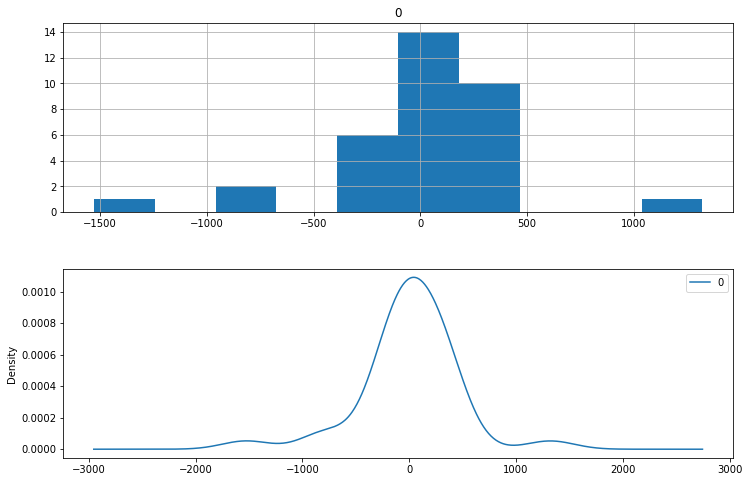


bias NOT saved in arg_dict["bias"] for subsequent run is: 8.559950134333442e-13 



In [46]:
# Load John Hopkins data
df, li_set = ld.driver(arg_dict)

# Get the date of the last row in the file to establish the currency of the data.
print(f'The "data date" is {df["Date_"].iloc[-1]}\n')

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Test for stationarity
df = st.driver(arg_dict)

# save df for subsequent independent processing
df.to_csv('df.csv')
      
# Grid search ARIMA parameters 
best_cfg = ags.driver(df, arg_dict)
arg_dict.update({'best_cfg': best_cfg})

# summarize residual errors for an ARIMA model and return bias
model_fit, test, predictions = summarize.driver(df, arg_dict)

# Rerun summarize, as bias adjusted
model_fit, test, predictions = summarize.driver(df, arg_dict)
arg_dict.update({'test': test, 'predictions': predictions, 'model_fit': model_fit})

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


The predicted cumulative Deaths for New York for tomorrow (input data plus 1 day) are 28,721


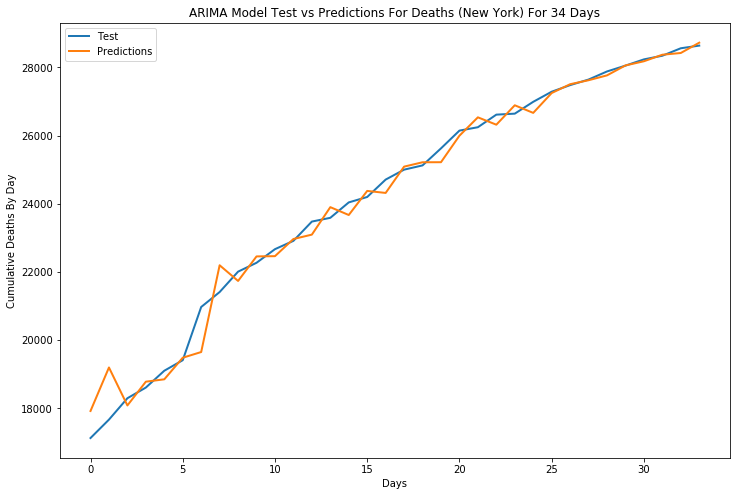

In [47]:
# Plot test (actual) vs predictions, save, and forecast
tpsf1.driver(arg_dict)

The New York prediction is for 121,049 cumulative Deaths to occur by 2020-12-31 00:00:00


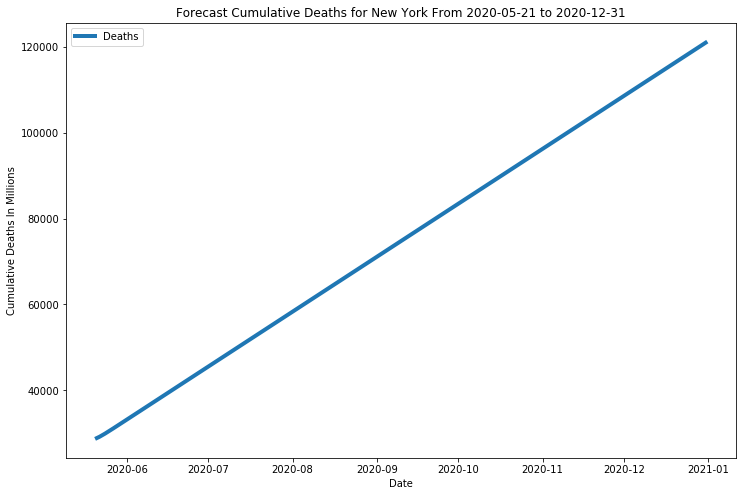

In [48]:
# Multi step forecast
df.index = pd.to_datetime(df.index)
forecast_df = msf.driver(df, arg_dict)

If the arg_dict has a prediction date later than the above date, the reason is that ARIMA expects the jurisdiction to flatten the curve by the date indicated. We truncate the prediction at that point.

In [49]:
df.tail()

,Deaths
Date_,
2020-05-16,28049.0
2020-05-17,28232.0
2020-05-18,28339.0
2020-05-19,28558.0
2020-05-20,28636.0


In [50]:
forecast_df.head()

,Deaths
Date_,
2020-05-21,28859.517378
2020-05-22,29164.128845
2020-05-23,29515.399773
2020-05-24,29893.184727
2020-05-25,30286.036152
